In [49]:
import os
import mne
import ndx_events
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices

from shared.helper_functions import save_figure, select_folder, select_or_create_folder
from settings_general import low_qual_chans, freq_bands_eeg, subject_id_batch_cage_dict

Change plot theme

In [50]:
sns.set_theme()

And define a palette to plot with

In [60]:
palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
palette_gr = {'DRD2-WT':'#6A8D73', 'DRD2-KO':'#984447'}
cmap_palette = 'YlOrBr'

Let the user select the needed folders

In [4]:
epoch_folder = select_folder("Select the folder that holds sociability experiment's epoch files")
plot_folder = select_or_create_folder("Create or select a folder the plots will be saved to")

In [5]:
epoch_folder

'C:/Users/Olle de Jong/Documents/MSc Biology/rp2/rp2_data/3C_sociability/output/epochs/one_sec_no_overlap'

In [6]:
plot_folder

'C:/Users/Olle de Jong/Documents/MSc Biology/rp2/rp2_data/3C_sociability/output/plots/one_sec_no_overlap'

Define the channels we're not interested in

In [7]:
excluded_chans = ['EMG_L', 'EMG_R']

Load all subject epochs

In [56]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif') or file.startswith('.'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [57]:
len(all_subject_epochs)

17

### Define some computation functions

In [62]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose='ERROR', gc_n_lags=40)
    return con.get_data(output='dense')

And a function that computes a dataframe holding the connectivity for all the subject's epochs.

In [63]:
def connectivity_df(subject_epoch_objects, subject_ids, method):
    print(f'Computing {method} connectivity for subjects:\n {subject_ids}')
    results_df = pd.DataFrame()
    
    # per subject, calculate the given measure for all epochs
    for subject_epochs in subject_epoch_objects:
        subject_id = int(subject_epochs.metadata['subject_id'].iloc[0])
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        if subject_id not in subject_ids:
            print(f'Not computing connectivity measure for subject {subject_id} because of quality')
            continue
        
        for interaction_kind in subject_epochs.metadata.interaction_kind.unique():
            
            interaction_kind_epochs = subject_epochs[subject_epochs.metadata['interaction_kind'] == interaction_kind]
            interaction_kind_epochs = interaction_kind_epochs.drop_channels(excluded_chans)
    
            # compute the given connectivity measure for every frequency band
            for band_name, (fmin, fmax) in freq_bands_eeg.items():
    
                # compute the connectivity using the provided method
                con = compute_con(interaction_kind_epochs, method, fmin, fmax)
                
                # loop through every channel combination
                for i in range(con.shape[1]):
                    for j in range(i+1, con.shape[0]):
                        if subject_id in low_qual_chans.keys():
                            if interaction_kind_epochs.ch_names[i] in low_qual_chans[subject_id] or interaction_kind_epochs.ch_names[j] in low_qual_chans[subject_id]:
                                continue
                        # add the data
                        results_df = pd.concat([results_df, pd.DataFrame({
                            'con' : con[j, i, 0],
                            'node1' : interaction_kind_epochs.ch_names[i],
                            'node2' : interaction_kind_epochs.ch_names[j],
                            'band' : band_name,
                            'subject_id': subject_id,
                            'genotype': genotype,
                            'interaction_kind': interaction_kind
                        }, index=[0])], ignore_index=True)
                        
    print(f'Done computing {method} connectivity.')
    return results_df

And also a function that allows us to generate a heatmap of the connectivity per channel combination

In [64]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

Let's double check how this works.

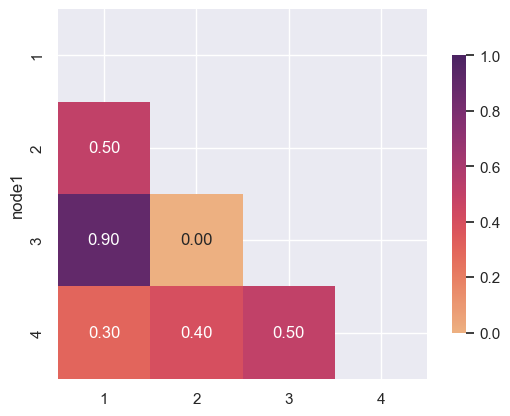

In [65]:
filtered_df = pd.DataFrame({
    'node1': [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
    'node2': [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4],
    'con':  [.1,.2,.3,.4,.5,.6,.7,.8,.9,.0,.1,.2,.3,.4,.5,.6,]
})

# generate pivot table with mean 'method' values
pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

# make table symmetric by filling missing values
pivot_table = pivot_table.combine_first(pivot_table.T)

# set diagonal and upper triangle values to NaN, this way we still plot all data
for i in range(pivot_table.shape[0]):
    for j in range(i, pivot_table.shape[1]):
        pivot_table.iat[i, j] = np.nan

fig = sns.heatmap(pivot_table, cmap='flare', annot=True, fmt=".2f", vmin=0, vmax=1, square=True, cbar_kws={'shrink': 0.75})

Now we can see that the reference signal (i, see the dPLI documentation) is on the left.

And a function that allows us to plot the connectivity differences between the two genotypes for the 4 channels of interest

In [70]:
def generate_grid_plot_wt_vs_ko(data, interaction_kind, method):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    freq_band_names = freq_bands_eeg.keys()
    genotypes = data['genotype'].unique()
    
    if method == 'dpli':  # as you interpret dpli differently, change the color palette to a diverging one
        cmap_palette = sns.color_palette('icefire')
    else:
        cmap_palette = 'YlOrBr'
        
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap_palette, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"connectivity/heatmaps/wt_vs_ko_{interaction_kind}_{method}.pdf"))

Lastly a function that allows us to generate barplots of the connectivity measures

In [67]:
def generate_barplots(data, interaction_kind, method):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 18), sharey=True, sharex=True)
    axs = axs.ravel()
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/barplots/grid_{interaction_kind}_{method}.pdf"))

## Exploration on a single subject (30958)

### Phase Lag Index exploration

#### Directed Phase-Lag-Index (dPLI)

In [36]:
for obj in all_subject_epochs:
    if obj.metadata.subject_id.iloc[0] == '39508':
        epochs_39508 = obj.copy()
        
epochs_39508.drop_channels(['S1_L', 'S1_R', 'V1_R', 'EMG_L', 'EMG_R'])
epochs_39508.info['ch_names']

In [37]:
fig = plt.figure(figsize=(16, 3))
plt.plot(epochs_39508[22].get_data(picks='CG')[0,0,:], label='GC')
plt.plot(epochs_39508[22].get_data(picks='STR_R')[0,0,:], label='STR_R')
plt.legend()

Visually, the STR_R seems to lag behind the GC, or the GC leads the STR_R

In [38]:
seeds = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
targets = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
indices = seed_target_indices(seeds, targets)
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
dpli_test = spectral_connectivity_epochs(
    epochs_39508[22], indices=indices, sfreq=epochs_39508.info['sfreq'], method="dpli", fmin=5, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {dpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(dpli_test.freqs)}')
print(f'\nThe dPLI output:\n {dpli_test.get_data(output="dense")}')

In [39]:
print(f'Mean dPLI for CG --> STR_R:  {np.average(dpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean dPLI for STR_R --> CG:  {np.average(dpli_test.get_data(output="dense")[3,2,:])}')

We can, from these, observe that they are each others opposites, which makes sense, as we calculate the **directed** phase-lag index here. If one leads or lags the other, the score of the reverse is gonna be the opposite. Note; the dPLI ranges from 0 to 1.

Now, how do we interpret this?

The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

So, the CG is leading the STR_R signal, or, the STR_R is lagging the CG signal.



#### Weighted Phase-Lag-Index (wPLI)


In [40]:
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
wpli_test = spectral_connectivity_epochs(
    epochs_39508[22], indices=indices, sfreq=epochs_39508.info['sfreq'], method="wpli", fmin=5, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {wpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(wpli_test.freqs)}')
print(f'\nThe dPLI output:\n {wpli_test.get_data(output="dense")}')

In [41]:
wpli_test.get_data(output="dense")[2,3,:]

In [42]:
print(f'Mean wPLI for CG --> STR_R:  {np.average(wpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean wPLI for STR_R --> CG:  {np.average(wpli_test.get_data(output="dense")[3,2,:])}')

The wPLI ranges from 0 to 1, where 0 means no phase synchronization, and 1.0 means perfect phase synchronization, which refers to a situation where two signals exhibit a constant and consistent phase relationship across time. In this specific epoch, that wPLI tells us that that is the case.

### Granger Causality exploration

In [43]:
# parietal sensors
signals_a = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "OFC_L"
]
# occipital sensors
signals_b = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "CG"
]

indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
print(indices_ab)
print(indices_ba)

In [44]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ab,
    fmin=5,
    fmax=25,
    gc_n_lags=20,
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ba,
    fmin=5,
    fmax=25,
    gc_n_lags=20,
)  # B => A
freqs = gc_ab.freqs
print(gc_ab.shape)
print(gc_ab)

In [45]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ab.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [OFC_L => CG]")
plt.show()

In [46]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ba.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [CG => OFC_L]")
plt.show()

In [47]:
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, net_gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Net Granger Causality: [OFC_L => CG] - [CG => OFC_L]")

By subtracting the flow of information from CG to OFC_L from the flow of information of the reverse we get the net granger causality.

This tells us, that for this specific epoch, there's more information flow from the Cingulate Cortex to the left Orbitalfrontal Cortex for most of the frequencies.


#### Time-traversed Granger Causality

In [48]:
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=5,
    fmax=25,
    gc_n_lags=20,
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=5,
    fmax=25,
    gc_n_lags=20,
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

Plot the net time-traversed GC

In [49]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("TRGC: net[OFC_L => CG] - net time-reversed[CG => OFC_L]")

Let's compute the net time-reversed granger causality for the frequencies 0 through 100 Hz.

In [50]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ab,
    fmin=1,
    fmax=100,
    gc_n_lags=20,
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ba,
    fmin=1,
    fmax=100,
    gc_n_lags=20,
)  # B => A
freqs = gc_ab.freqs
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=1,
    fmax=100,
    gc_n_lags=20,
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=1,
    fmax=100,
    gc_n_lags=20,
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => CG] - net time-reversed[CG => OFC_L]")
plt.show()

Remember that positive values of connectivity mean that there's more information flow from the CG to the OFC_L.

## Connectivity for social versus non-social cup interaction epochs

First select subjects of which we know the quality is sufficient.

In [17]:
wt_ids = [sub_obj.metadata["subject_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-WT"]
ko_ids = [sub_obj.metadata["subject_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-KO"]
print(wt_ids)
print(ko_ids)

['39508', '78233', '78244', '79602', '80620', '80630', '81207', '81217']
['39489', '78211', '78227', '79592', '79604', '80625', '81175', '81193', '81218']


Based on the sociability 'eeg_power_analysis' notebook, we remove 81217, 81193, and 39489.

In [18]:
[wt_ids.remove(x) for x in ['81217', '81193', '39489'] if x in wt_ids]
[ko_ids.remove(x) for x in ['81217', '81193', '39489'] if x in ko_ids]
print(wt_ids)
print(ko_ids)

['39508', '78233', '78244', '79602', '80620', '80630', '81207']
['78211', '78227', '79592', '79604', '80625', '81175', '81218']


In [19]:
passed_subject_ids = wt_ids + ko_ids
passed_subject_ids = [int(x) for x in passed_subject_ids]
passed_subject_ids

[39508,
 78233,
 78244,
 79602,
 80620,
 80630,
 81207,
 78211,
 78227,
 79592,
 79604,
 80625,
 81175,
 81218]



### Coherence (coh)

In [24]:
coh = connectivity_df(all_subject_epochs, passed_subject_ids, "coh")
coh.shape

Computing coh connectivity for subjects:
 [39508, 78233, 78244, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79604, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality
Not computing connectivity measure for subject 81193 because of quality
Not computing connectivity measure for subject 81217 because of quality
Done computing coh connectivity.


(2880, 7)

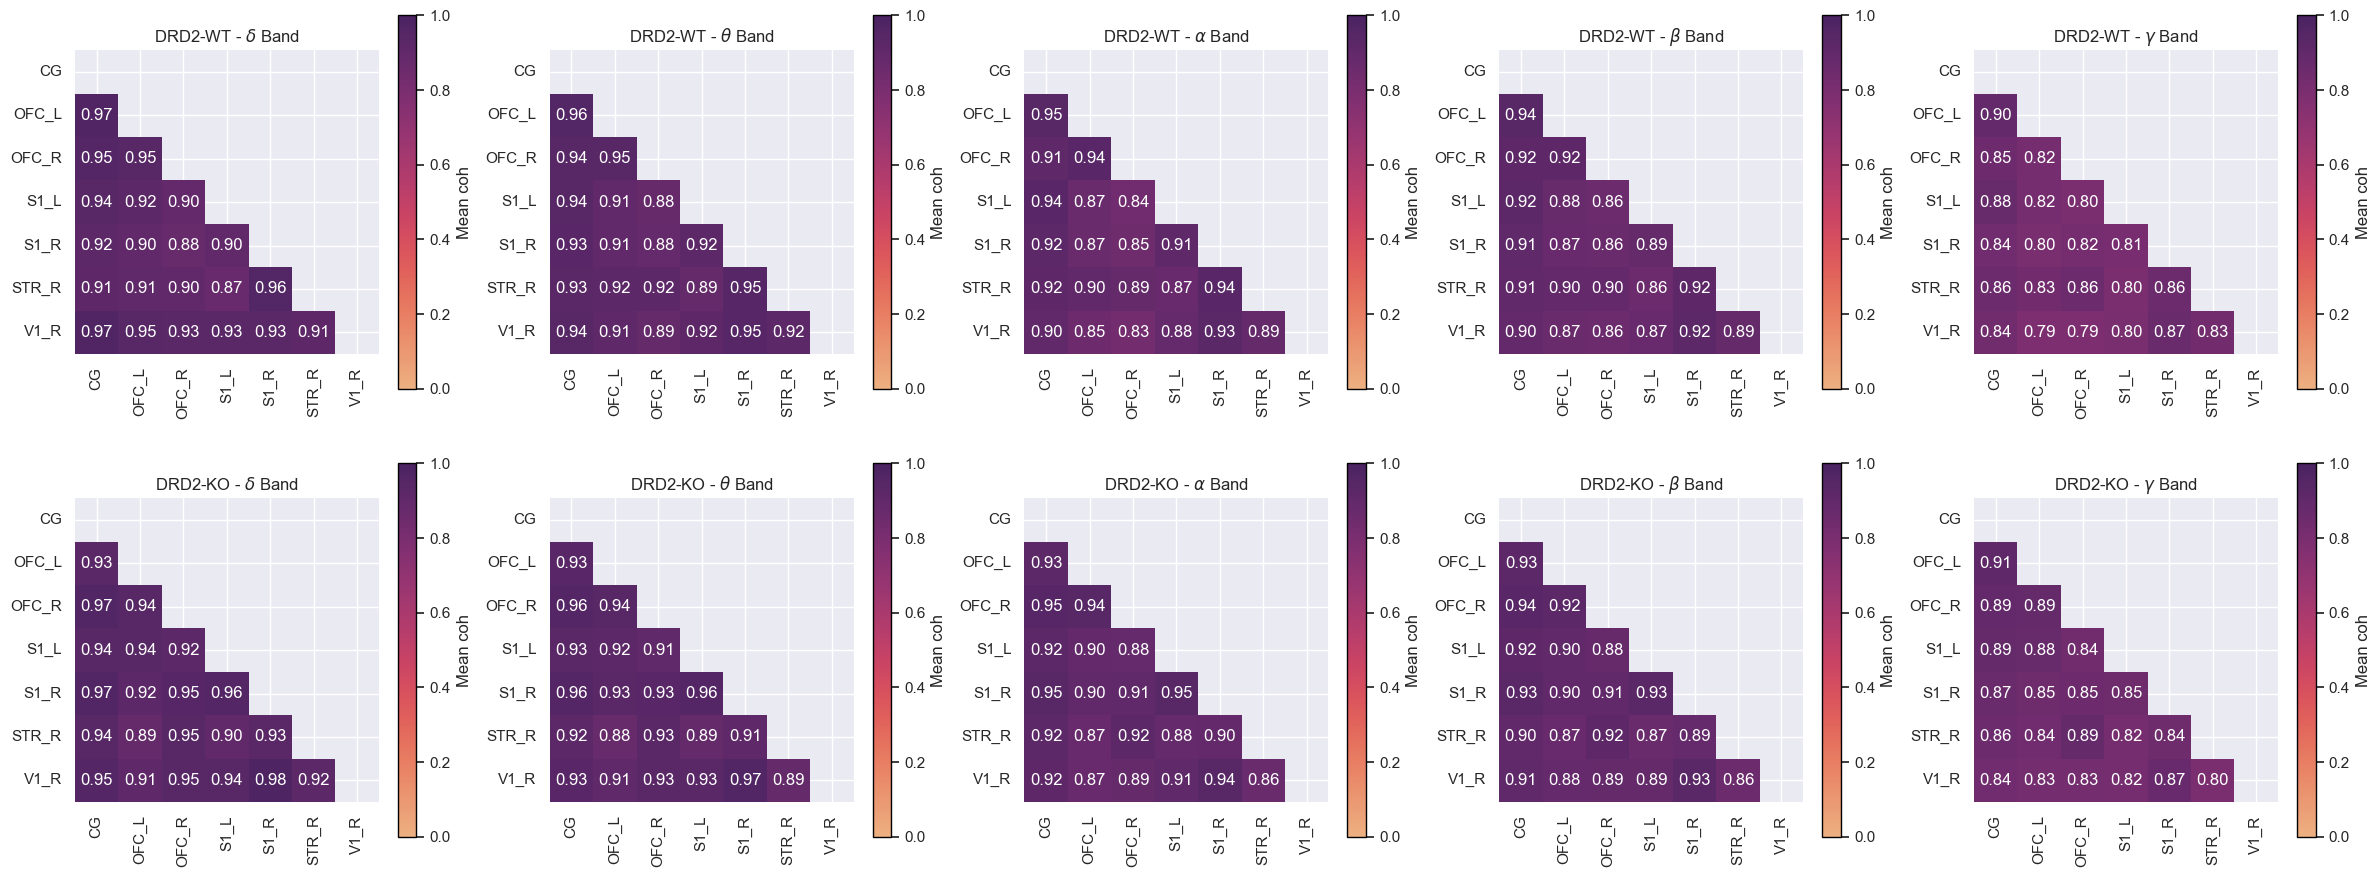

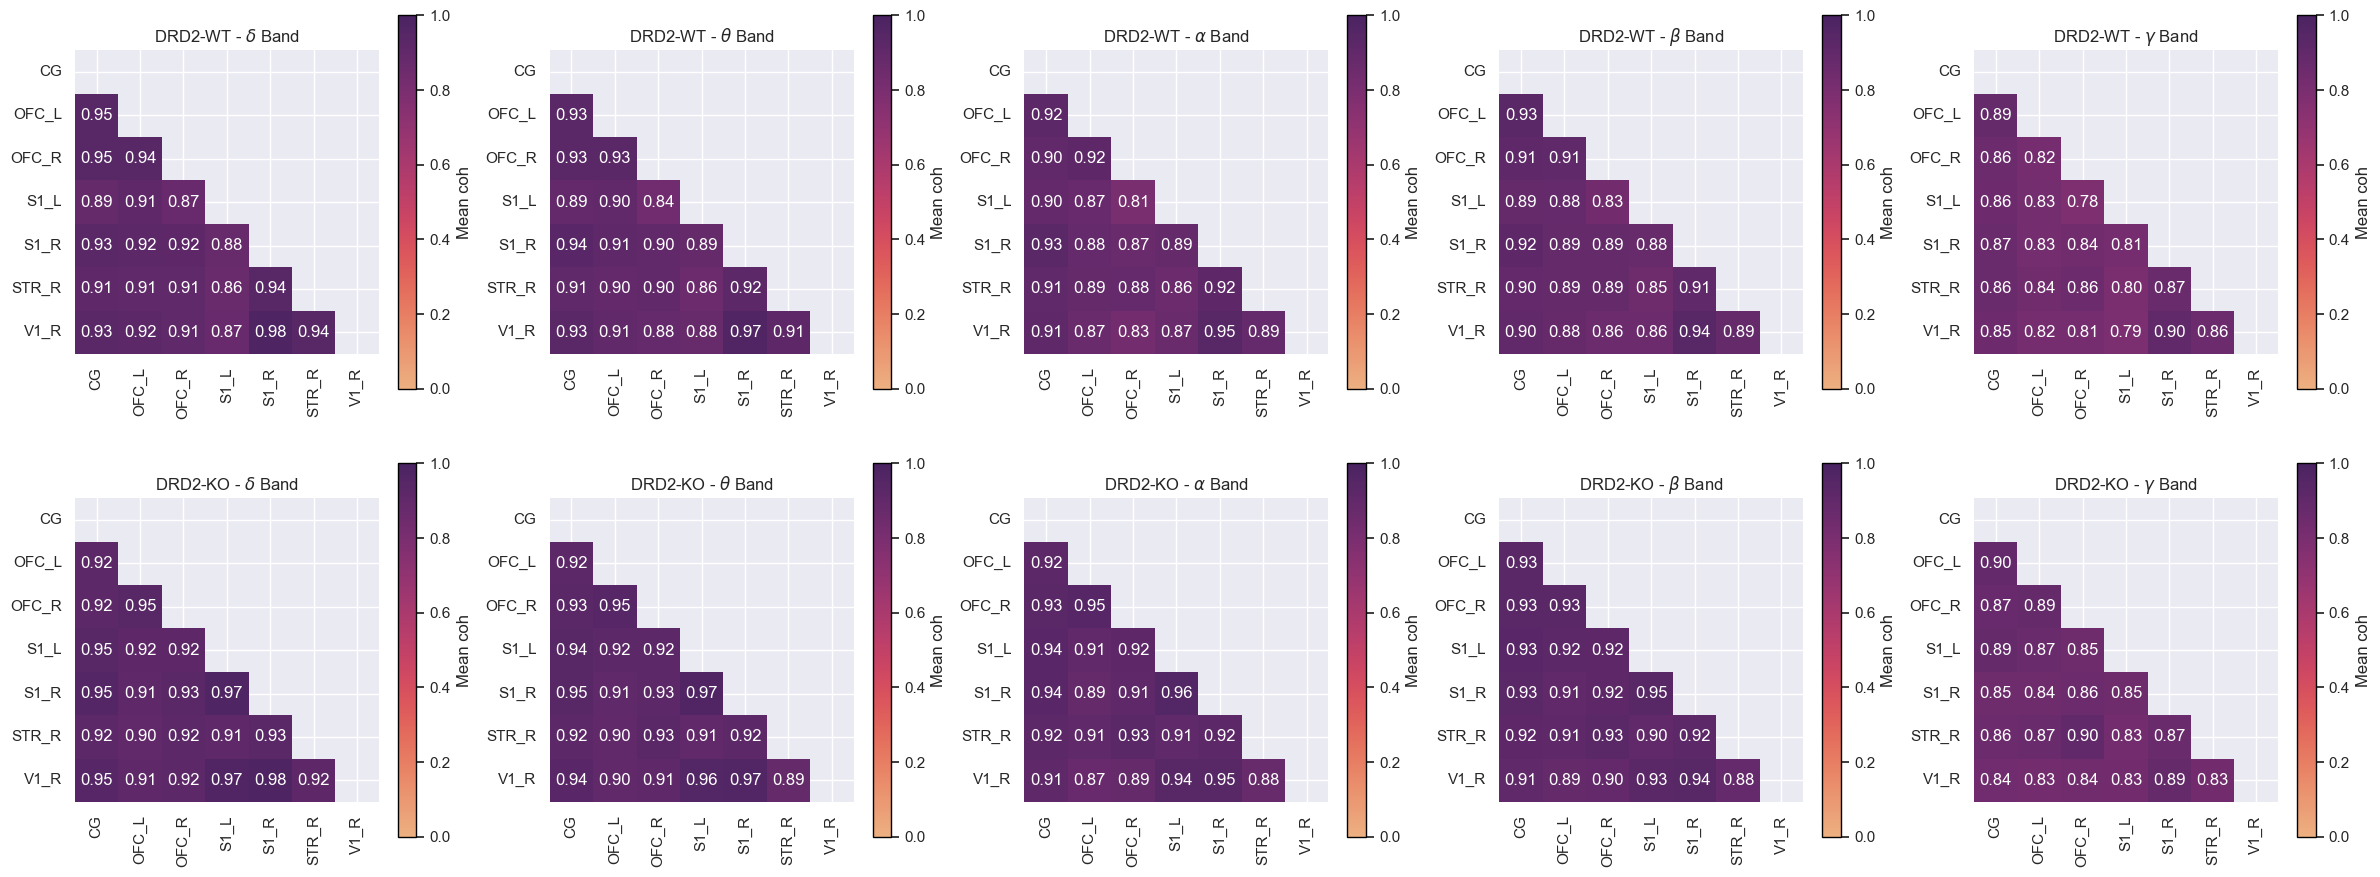

In [25]:
generate_grid_plot_wt_vs_ko(coh[coh.interaction_kind == 'social_cup'], 'social_cup', 'coh')
generate_grid_plot_wt_vs_ko(coh[coh.interaction_kind == 'non-social_cup'], 'non-social_cup', 'coh')

In [18]:
generate_barplots(coh[coh.interaction_kind == 'social_cup'], 'social_cup', 'coh')
generate_barplots(coh[coh.interaction_kind == 'non-social_cup'], 'non-social_cup', 'coh')

### Directed Phase Lag Index (dPLI)

In [26]:
dpli = connectivity_df(all_subject_epochs, passed_subject_ids, "dpli")
dpli.shape

Computing dpli connectivity for subjects:
 [39508, 78233, 78244, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79604, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality
Not computing connectivity measure for subject 81193 because of quality
Not computing connectivity measure for subject 81217 because of quality
Done computing dpli connectivity.


(2880, 7)

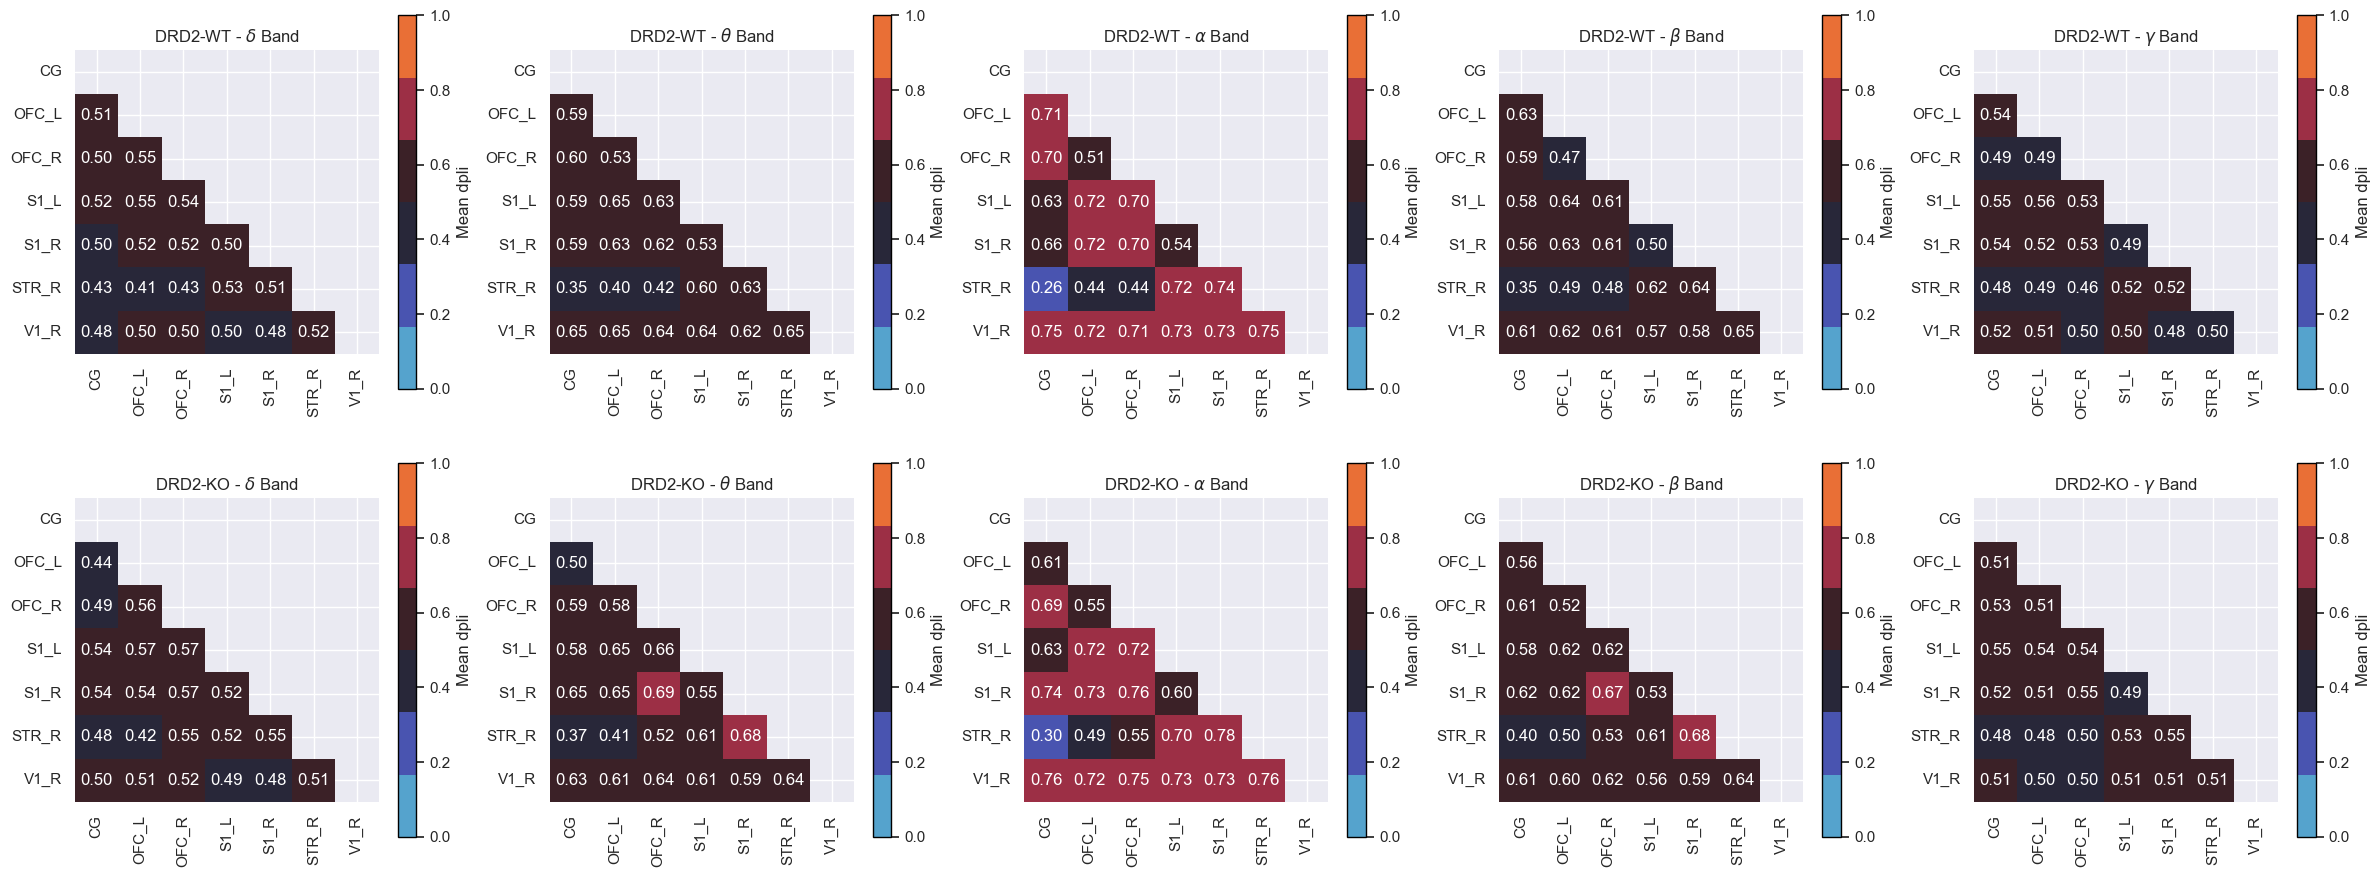

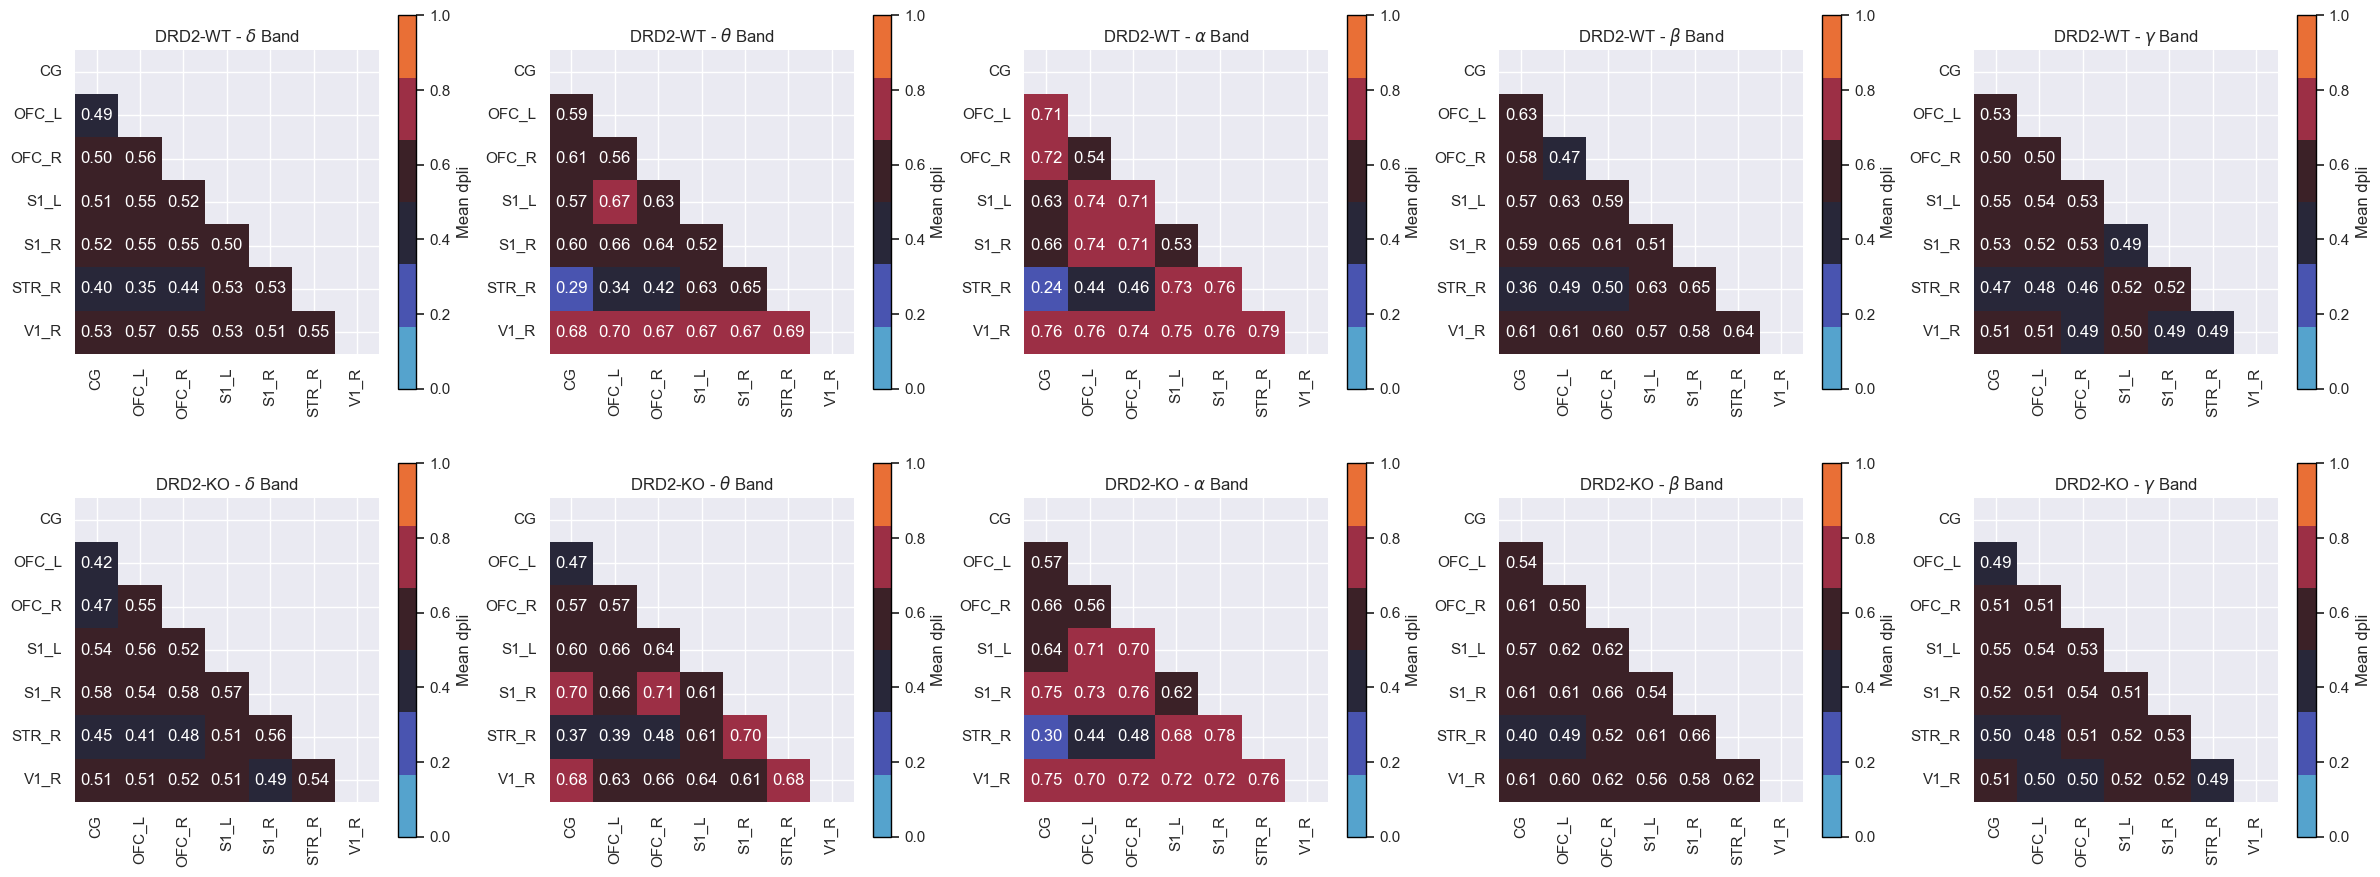

In [31]:
generate_grid_plot_wt_vs_ko(dpli[dpli.interaction_kind == 'social_cup'], 'social_cup', 'dpli')
generate_grid_plot_wt_vs_ko(dpli[dpli.interaction_kind == 'non-social_cup'], 'non-social_cup', 'dpli')

In [18]:
generate_barplots(dpli[dpli.interaction_kind == 'social_cup'], 'social_cup', 'dpli')
generate_barplots(dpli[dpli.interaction_kind == 'non-social_cup'], 'non-social_cup', 'dpli')

### Weighted Phase Lag Index (wPLI)

In [68]:
wpli = connectivity_df(all_subject_epochs, passed_subject_ids, "wpli")
wpli.shape

Computing wpli connectivity for subjects:
 [39508, 78233, 78244, 79602, 80620, 80630, 81207, 78211, 78227, 79592, 79604, 80625, 81175, 81218]
Not computing connectivity measure for subject 39489 because of quality
Not computing connectivity measure for subject 81193 because of quality
Not computing connectivity measure for subject 81217 because of quality
Done computing wpli connectivity.


(2880, 7)

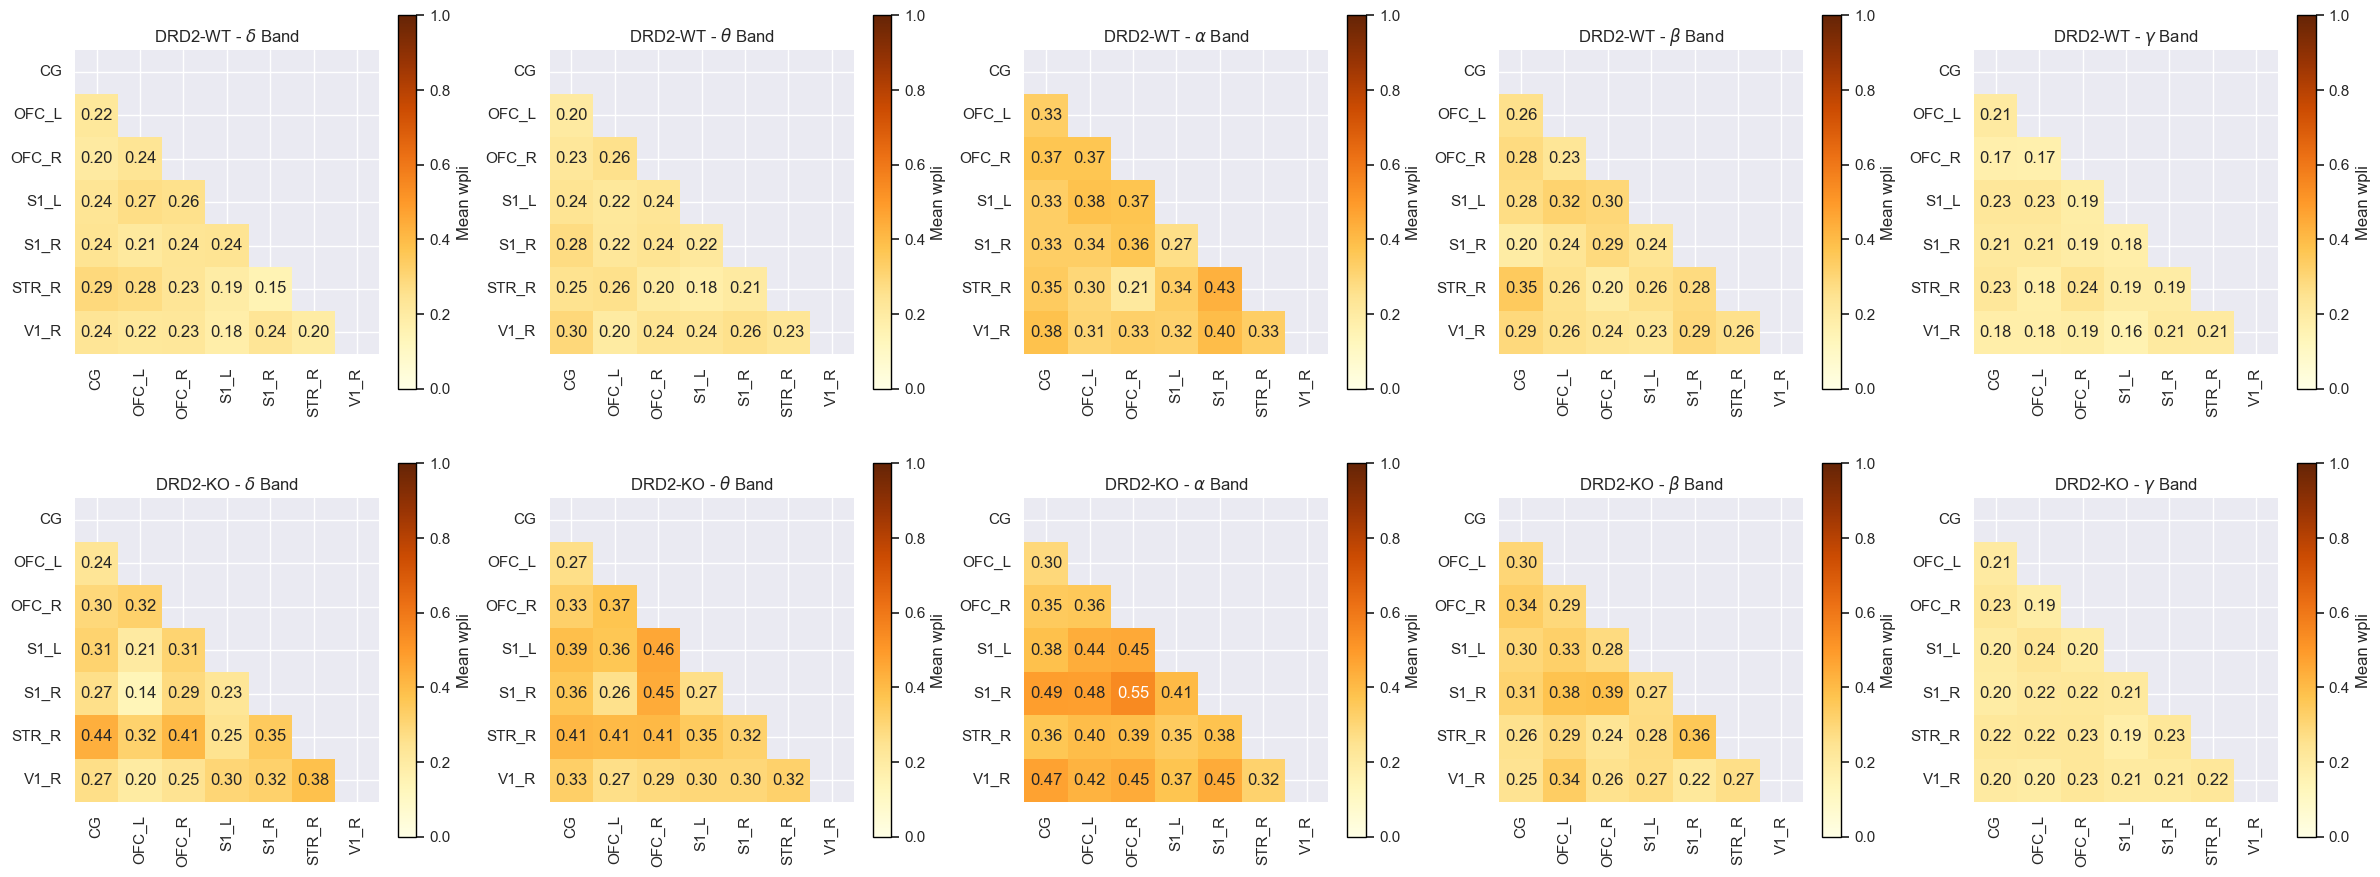

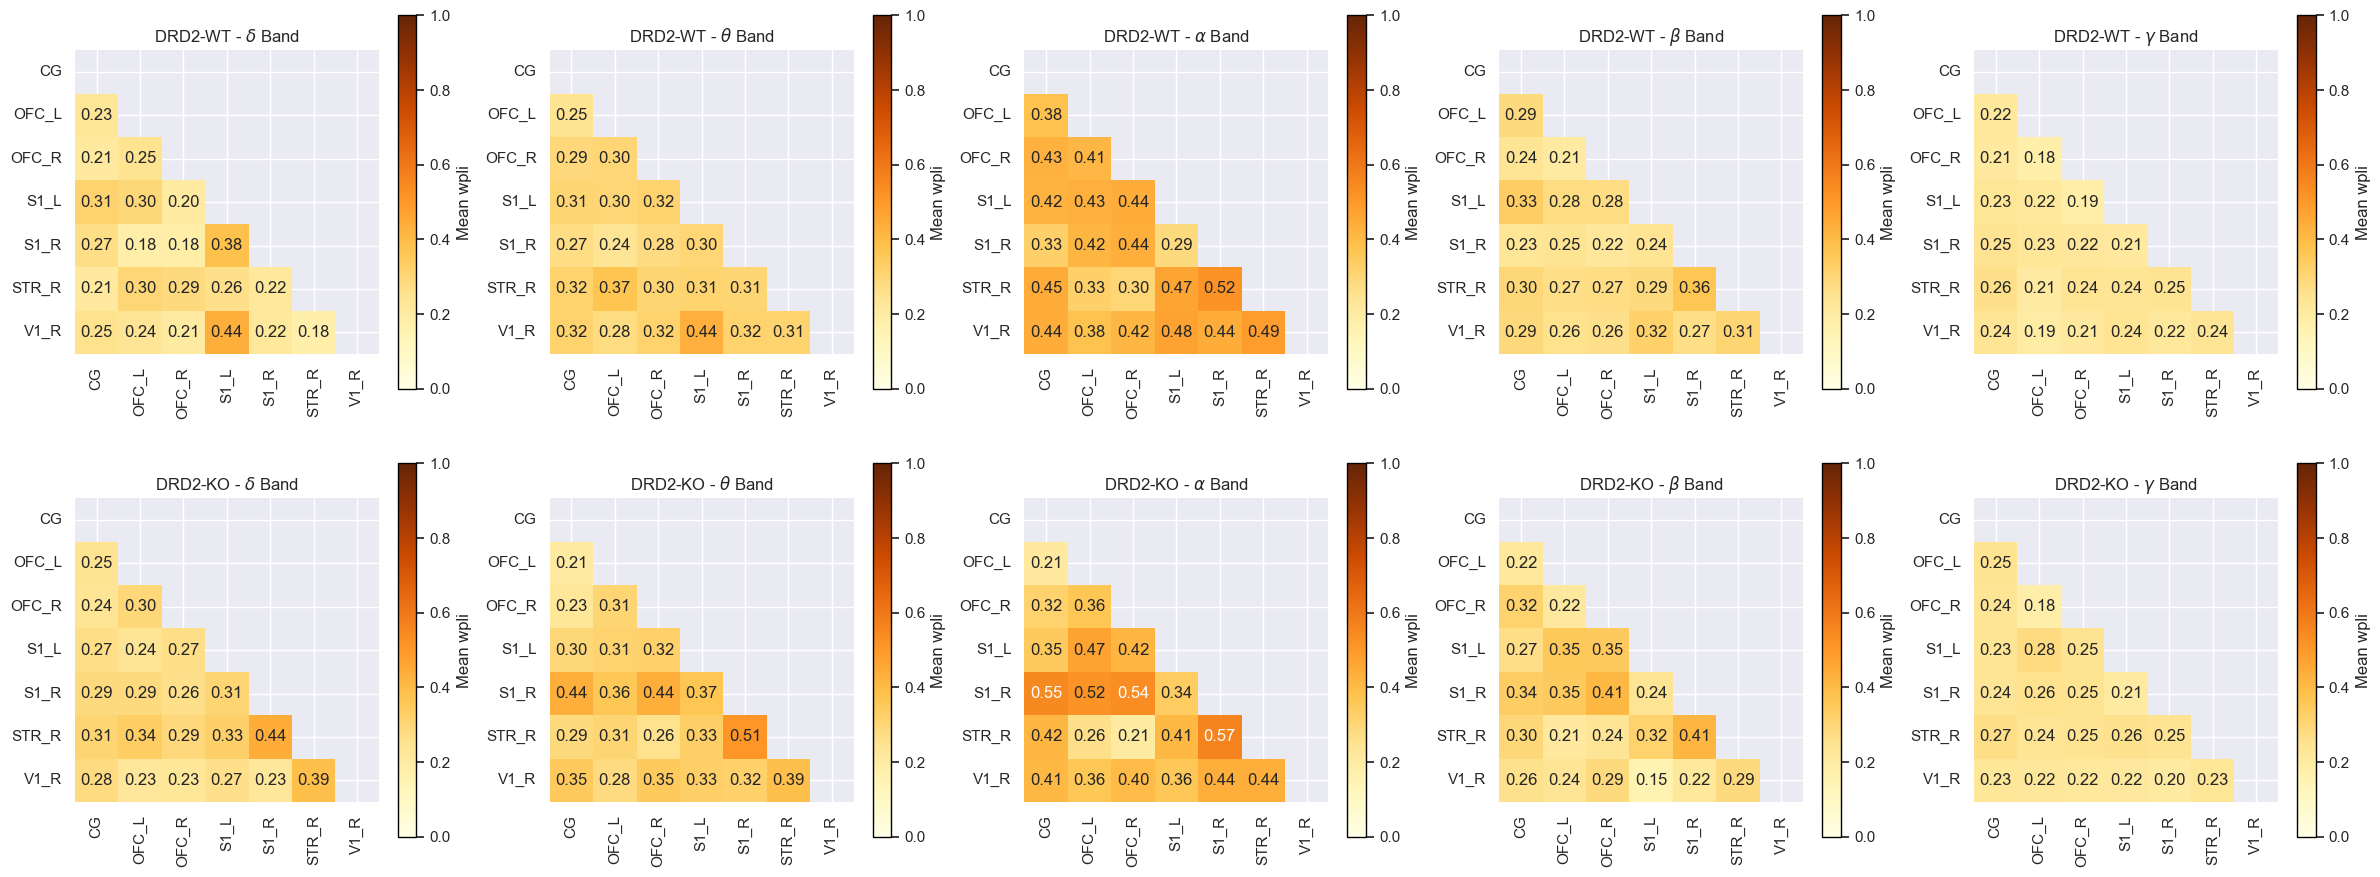

In [72]:
generate_grid_plot_wt_vs_ko(wpli[wpli.interaction_kind == 'social_cup'], 'social_cup', 'wpli')
generate_grid_plot_wt_vs_ko(wpli[wpli.interaction_kind == 'non-social_cup'], 'non-social_cup', 'wpli')

In [18]:
generate_barplots(wpli[wpli.interaction_kind == 'social_cup'], 'social_cup', 'wpli')
generate_barplots(wpli[wpli.interaction_kind == 'non-social_cup'], 'non-social_cup', 'wpli')

### Debiased estimator of squared WPLI (wPLI-2 debiased)

In [31]:
wpli2_social = connectivity_df(all_subject_epochs, 'social_cup', "wpli2_debiased")
wpli2_non_social = connectivity_df(all_subject_epochs, 'non-social_cup', "wpli2_debiased")
wpli2_social.head()

In [32]:
generate_grid_plot_wt_vs_ko(wpli2_social, 'social_cup', 'wpli2_debiased')
generate_grid_plot_wt_vs_ko(wpli2_non_social, 'non-social_cup', 'wpli2_debiased')

In [33]:
generate_barplots(wpli2_social, 'social_cup', 'wpli2_debiased')
generate_barplots(wpli2_non_social, 'non-social_cup', 'wpli2_debiased')

### Pairwise Phase Consistency (PPC)

In [34]:
ppc_social = connectivity_df(all_subject_epochs, 'social_cup', "ppc")
ppc_non_social = connectivity_df(all_subject_epochs, 'non-social_cup', "ppc")
ppc_social.head()

In [35]:
generate_grid_plot_wt_vs_ko(ppc_social, 'social_cup', 'ppc')
generate_grid_plot_wt_vs_ko(ppc_non_social, 'non-social_cup', 'ppc')

In [36]:
generate_barplots(ppc_social, 'social_cup', 'ppc')
generate_barplots(ppc_non_social, 'non-social_cup', 'ppc')

## Multivariate connectivity analysis

Compute the multivariate connectivity measures for all subject's epochs

#### First, we use all EEG channels

Now, we also include the skull electrodes, and of course still exclude the EMGs

In [39]:
from pynwb import NWBHDF5IO

results_df = pd.DataFrame()

# for each subject, get the resting/active/sleep epochs, drop the emg channels and calculate the mic and mim
for subj_epochs in all_subject_epochs:
    subject_id = int(subj_epochs.metadata['subject_id'].iloc[0])
    batch = subject_id_batch_cage_dict[subject_id].split('_')[0]
    genotype = subj_epochs.metadata['genotype'].iloc[0]
    
    nwb_path = fr"C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\3C_sociability\output\nwb\3c_sociability_{subject_id}.nwb"
    with NWBHDF5IO(nwb_path, "r") as io:
        nwb = io.read()
        transmitter_id = list(nwb.devices.keys())[0]
    
    if subject_id in [81217, 81193, 39489]:
        print(f'Skipping subject {subject_id} as its quality was not sufficient (determined in power/connectivity notebooks)')
        continue
    
    to_drop = [x for x in ['EMG_L', 'EMG_R'] if x in subj_epochs.info['ch_names']]
    subj_epochs = subj_epochs.load_data().drop_channels(to_drop)
    
    for behaviour in ['social_cup', 'non-social_cup']:
        state_epochs = subj_epochs[subj_epochs.metadata['interaction_kind'] == behaviour]

        (mic, mim) = spectral_connectivity_epochs(state_epochs, method=['mic', 'mim'], n_jobs=-1, fmin=1, fmax=100, verbose='ERROR')
    
        results_df = pd.concat([results_df, pd.DataFrame({
            'animal_id' : subject_id,
            'genotype' : genotype,
            'batch': batch,
            'transmitter': transmitter_id,
            'behaviour': behaviour,
            'freqs' : mic.freqs,
            'mic' : mic.get_data()[0,:],
            'mim' : mim.get_data()[0,:]
        })])

Skipping subject 39489 as its quality was not sufficient (determined in power/connectivity notebooks)
Skipping subject 81193 as its quality was not sufficient (determined in power/connectivity notebooks)
Skipping subject 81217 as its quality was not sufficient (determined in power/connectivity notebooks)


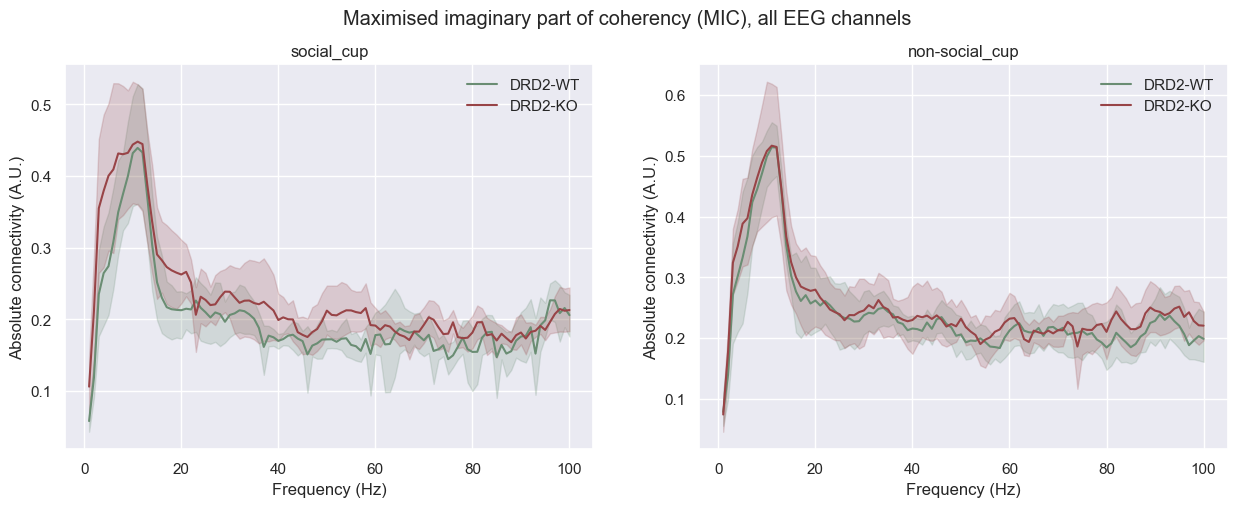

In [41]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df.behaviour.unique()):
    results = results_df.loc[(results_df['behaviour'] == interaction_kind)]
    
    sns.lineplot(x=results.freqs, y=np.abs(results.mic), hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='best', frameon=False)
    
fig.suptitle("Maximised imaginary part of coherency (MIC), all EEG channels", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mic.pdf"))

In [44]:
results_df.to_excel(r"C:\Users\Olle de Jong\Desktop\data_mim_mic_3cs.xlsx")

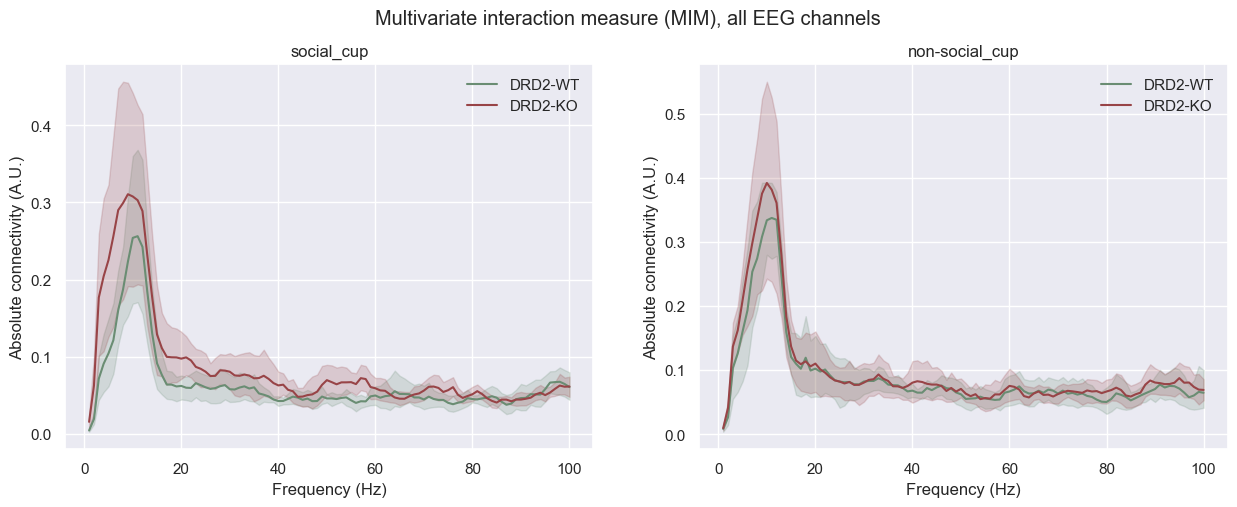

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df.behaviour.unique()):
    results = results_df.loc[(results_df['behaviour'] == interaction_kind)]
    
    sns.lineplot(x=results.freqs, y=results.mim, hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='best', frameon=False)
    
fig.suptitle("Multivariate interaction measure (MIM), all EEG channels", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mim.pdf"))

In [40]:
for interaction_kind in results_df.behaviour.unique():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 11))
    axs = axs.ravel()
    results = results_df.loc[(results_df['behaviour'] == interaction_kind) & (results_df['low_qual_chans'] == False)]
    
    for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
        slice_data = results[(results.freqs >= start) & (results.freqs <= end)]
        sns.lineplot(x=slice_data.freqs, y=np.abs(slice_data.mic), hue=slice_data.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
        axs[i].set_title(f'{interaction_kind} - band: {band}')
    
    fig.suptitle("Maximised imaginary part of coherency (MIC) per band, all EEG channels", y=0.99)
    axs[-1].remove()
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/multivariate/mic_parts_{interaction_kind}.pdf"))

In [41]:
for interaction_kind in results_df.behaviour.unique():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 11))
    axs = axs.ravel()
    results = results_df.loc[results_df['behaviour'] == interaction_kind]
    
    for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
        slice_data = results[(results.freqs >= start) & (results.freqs <= end)]
        sns.lineplot(x=slice_data.freqs, y=slice_data.mim, hue=slice_data.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
        axs[i].set_title(f'{interaction_kind} - band: {band}')
    
    fig.suptitle("Multivariate interaction measure (MIM) per band, all EEG channels", y=0.99)
    axs[-1].remove()
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"connectivity/multivariate/mim_parts_{interaction_kind}.pdf"))

#### Now we do the same, but using only the depth electrodes

In [45]:
from pynwb import NWBHDF5IO

results_df = pd.DataFrame()

# for each subject, get the resting/active/sleep epochs, drop the emg channels and calculate the mic and mim
for subj_epochs in all_subject_epochs:
    subject_id = int(subj_epochs.metadata['subject_id'].iloc[0])
    batch = subject_id_batch_cage_dict[subject_id].split('_')[0]
    genotype = subj_epochs.metadata['genotype'].iloc[0]
    
    nwb_path = fr"C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\3C_sociability\output\nwb\3c_sociability_{subject_id}.nwb"
    with NWBHDF5IO(nwb_path, "r") as io:
        nwb = io.read()
        transmitter_id = list(nwb.devices.keys())[0]
    
    if subject_id in [81217, 81193, 39489]:
        print(f'Skipping subject {subject_id} as its quality was not sufficient (determined in power/connectivity notebooks)')
        continue
    
    to_drop = [x for x in ['S1_L', 'S1_R', 'V1_R', 'EMG_L', 'EMG_R'] if x in subj_epochs.info['ch_names']]
    subj_epochs = subj_epochs.load_data().drop_channels(to_drop)
    
    for behaviour in ['social_cup', 'non-social_cup']:
        state_epochs = subj_epochs[subj_epochs.metadata['interaction_kind'] == behaviour]

        (mic, mim) = spectral_connectivity_epochs(state_epochs, method=['mic', 'mim'], n_jobs=-1, fmin=1, fmax=100, verbose='ERROR')
    
        results_df = pd.concat([results_df, pd.DataFrame({
            'animal_id' : subject_id,
            'genotype' : genotype,
            'batch': batch,
            'transmitter': transmitter_id,
            'behaviour': behaviour,
            'freqs' : mic.freqs,
            'mic' : mic.get_data()[0,:],
            'mim' : mim.get_data()[0,:]
        })])

Skipping subject 39489 as its quality was not sufficient (determined in power/connectivity notebooks)
Skipping subject 81193 as its quality was not sufficient (determined in power/connectivity notebooks)
Skipping subject 81217 as its quality was not sufficient (determined in power/connectivity notebooks)


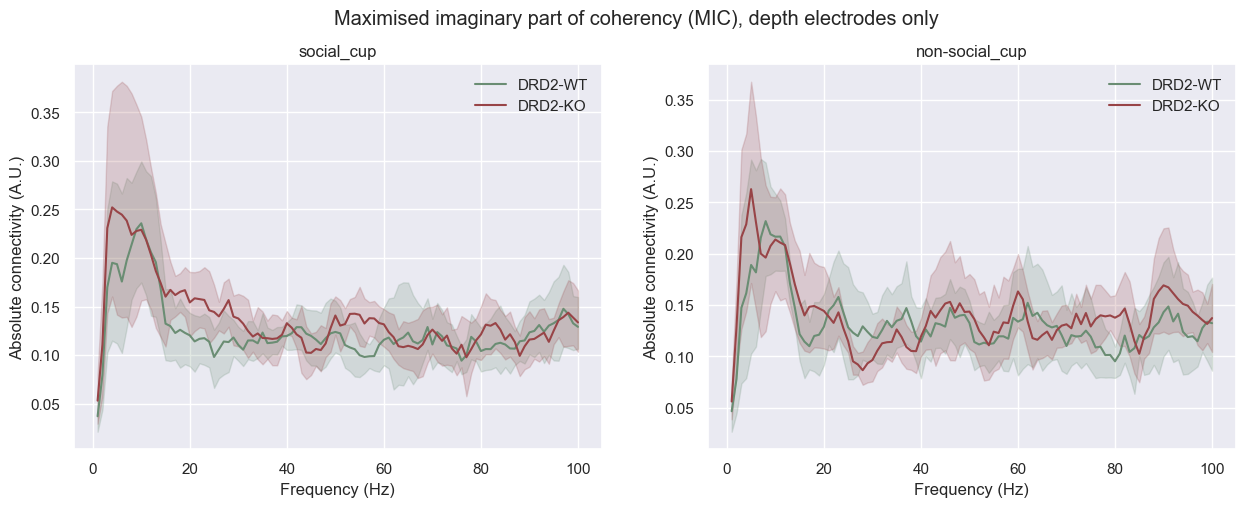

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df.behaviour.unique()):
    results = results_df.loc[(results_df['behaviour'] == interaction_kind)]
    
    sns.lineplot(x=results.freqs, y=np.abs(results.mic), hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='best', frameon=False)
    
fig.suptitle("Maximised imaginary part of coherency (MIC), depth electrodes only", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mic_depth_electrodes_only.pdf"))

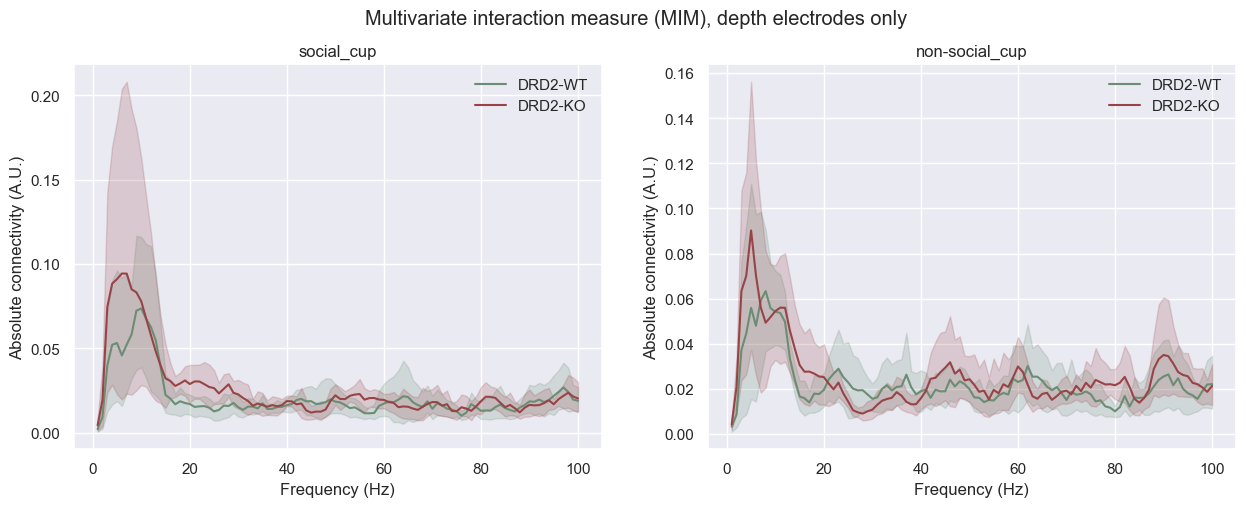

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs = axs.ravel()

for i, interaction_kind in enumerate(results_df.behaviour.unique()):
    results = results_df[(results_df['behaviour'] == interaction_kind)]
    
    sns.lineplot(x=results.freqs, y=results.mim, hue=results.genotype, errorbar=('ci', 95), ax=axs[i], palette=palette_gr)
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Absolute connectivity (A.U.)")
    axs[i].set_title(interaction_kind)
    axs[i].legend(loc='best', frameon=False)
    
fig.suptitle("Multivariate interaction measure (MIM), depth electrodes only", y=0.99)
save_figure(os.path.join(plot_folder, f"connectivity/multivariate/total_mim_depth_electrodes_only.pdf"))

In [48]:
results_df.to_excel(r"C:\Users\Olle de Jong\Desktop\data_mim_mic_3cs_DMN.xlsx")

In [46]:
for interaction_kind in results_df.behaviour.unique():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 11))
    axs = axs.ravel()
    results = results_df[(results_df['behaviour'] == interaction_kind) & (results_df['low_qual_chans'] == False)]
    
    for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
        slice_data = results[(results.freqs >= start) & (results.freqs <= end)]
        sns.lineplot(x=slice_data.freqs, y=np.abs(slice_data.mic), hue=slice_data.genotype, errorbar='se', ax=axs[i], palette=palette_gr)
        axs[i].set_title(f'{interaction_kind} - band: {band}')
    
    fig.suptitle("Maximised imaginary part of coherency (MIC) per band, depth electrodes only", y=0.99)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f"connectivity/multivariate/mic_parts_{interaction_kind}_depth_electrodes_only.pdf"))

Now for the MIM

In [47]:
for interaction_kind in results_df.behaviour.unique():
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 11))
    axs = axs.ravel()
    results = results_df.loc[(results_df['behaviour'] == interaction_kind) & (results_df['low_qual_chans'] == False)]
    
    for i, (band, (start, end)) in enumerate(freq_bands_eeg.items()):
        slice_data = results[(results.freqs >= start) & (results.freqs <= end)]
        sns.lineplot(x=slice_data.freqs, y=slice_data.mim, hue=slice_data.genotype, errorbar='se', ax=axs[i], palette=palette_gr)
        axs[i].set_title(f'{interaction_kind} - band: {band}')
    
    fig.suptitle("Multivariate interaction measure (MIM) per band, depth electrodes only", y=0.99)
    plt.tight_layout()
    axs[-1].remove()
    save_figure(os.path.join(plot_folder, f"connectivity/multivariate/mim_parts_{interaction_kind}_depth_electrodes_only.pdf"))

## WT vs KO gridplot of averaged time-reversed Granger Causality

In [48]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    if not file.endswith('.fif') or file.startswith('.'):
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True, verbose='WARNING'))

In [49]:
def compute_indices(subject_epochs, channel_a, channel_b):
    signals_a = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_a
    ]
    # occipital sensors
    signals_b = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_b
    ]
    
    indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
    indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
    
    return indices_ab, indices_ba

In [50]:
def get_tr_gc(all_subject_epochs, interaction_kind, channel_a, channel_b):
    wt_trgcs, ko_trgcs = [], []
    
    for subject_epochs in all_subject_epochs:
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        indices_ab, indices_ba = compute_indices(subject_epochs, channel_a, channel_b)
        
        interaction_kind_epochs = subject_epochs[subject_epochs.metadata['interaction_kind'] == interaction_kind]
        interaction_kind_epochs = interaction_kind_epochs.drop_channels(['EMG_L', 'EMG_R'])
        
        gc_ab = spectral_connectivity_epochs(
            interaction_kind_epochs,
            method=["gc"],
            indices=indices_ab,
            fmin=1,
            fmax=100,
            gc_n_lags=20,
            verbose='ERROR'
        )  # A => B
        gc_ba = spectral_connectivity_epochs(
            interaction_kind_epochs,
            method=["gc"],
            indices=indices_ba,
            fmin=1,
            fmax=100,
            gc_n_lags=20,
            verbose='ERROR'
        )  # B => A
        freqs = gc_ab.freqs
        net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
        # compute GC on time-reversed signals
        gc_tr_ab = spectral_connectivity_epochs(
            interaction_kind_epochs,
            method=["gc_tr"],
            indices=indices_ab,
            fmin=1,
            fmax=100,
            gc_n_lags=20,
            verbose='ERROR'
        )  # TR[A => B]
        gc_tr_ba = spectral_connectivity_epochs(
            interaction_kind_epochs,
            method=["gc_tr"],
            indices=indices_ba,
            fmin=1,
            fmax=100,
            gc_n_lags=20,
            verbose='ERROR'
        )  # TR[B => A]
        
        # compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
        net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()
        
        # compute TRGC
        trgc = net_gc - net_gc_tr
        
        wt_trgcs.append(trgc) if genotype == "DRD2-WT" else ko_trgcs.append(trgc)
        
    return freqs, wt_trgcs, ko_trgcs

Chans to compute granger causality for

In [51]:
chans = all_subject_epochs[0].info['ch_names']
chans = [chan for chan in chans if chan not in ['EMG_L', 'EMG_R']]
chans

Compute for both social_cup and non-social_cup interactions

In [52]:
for interaction_kind in ['social_cup', 'non-social_cup']:
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 18), sharey=True, sharex=True)
    axs = axs.ravel()
    
    grid_index = 0
    for i in range(len(chans)):
        for j in range(i + 1, len(chans)):
            freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, interaction_kind, chans[i], chans[j])
            
            averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
            averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)
            
            axs[grid_index].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
            axs[grid_index].plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
            axs[grid_index].plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
            axs[grid_index].legend()
            for band, (start, end) in freq_bands_eeg.items():
                axs[grid_index].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
                axs[grid_index].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
                axs[grid_index].text((start + end) / 2, axs[grid_index].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
            axs[grid_index].set_title(f'Time-reversed GC: net[{chans[i]} => {chans[j]}]')
            grid_index += 1
    
    save_figure(os.path.join(plot_folder, f"connectivity/TRGC_{interaction_kind}_grid.pdf"))